In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import ast
from gensim.models import Word2Vec
pd.options.mode.chained_assignment = None

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv("/Users/tristanmoser/Files/Coding/Machine_Learning/Project/ted_main.csv")

In [4]:
len(data['main_speaker'].unique())

2156

In [5]:
data.head(1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110


## Ratings

In [6]:
data['ratings'][0]

"[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]"

In [7]:
ratings = ['Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
           'Informative', 'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
           'Obnoxious', 'Inspiring']

In [8]:
rate = []
def parse(x):
    for ll in range(len(data)):
        splitting = data['ratings'][ll].split(x)
        splitting2 = splitting[1].split(':')
        splitting3 = splitting2[1].split(" ")
        splitting4 = splitting3[1].split("}")
        rate.append(splitting4[0])
        series = pd.Series(rate)
        data[x] = series

In [9]:
for rating in ratings:
    parse(rating)
    rate.clear()

In [10]:
data[ratings].head()

,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413
2,964,60,183,45,78,27,395,166,104,230,54,146,142,230
3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070
4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893


## Tags

In [11]:
data['tags'].head()

0    ['children', 'creativity', 'culture', 'dance',...
1    ['alternative energy', 'cars', 'climate change...
2    ['computers', 'entertainment', 'interface desi...
3    ['MacArthur grant', 'activism', 'business', 'c...
4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object

In [12]:
data['tags'][9]

"['Christianity', 'God', 'culture', 'happiness', 'leadership', 'motivation', 'philanthropy', 'religion']"

In [13]:
ast.literal_eval(data['tags'][9])

['Christianity',
 'God',
 'culture',
 'happiness',
 'leadership',
 'motivation',
 'philanthropy',
 'religion']

In [14]:
destring = []
for number in range(len(data)):
    destring.append(ast.literal_eval(data['tags'][number]))
data['Tags'] = pd.Series(destring)

In [15]:
data['Tags'][9]

['Christianity',
 'God',
 'culture',
 'happiness',
 'leadership',
 'motivation',
 'philanthropy',
 'religion']

In [16]:
data['Tags'][9][0]

'Christianity'

In [17]:
data['Tags'][9].count("Christianity")

1

In [18]:
all_tags = []
for items in data['Tags']:
    all_tags.extend(items)

In [ ]:
#simplify = {"children":"family","creativity":'','culture':'',"dance":'', "education":'', "parenting":"family",
#            "teaching":'education','alternative energy':'','cars':'','climate change': 'environment',
#            'global issues':'','science':'',}

In [19]:
all_tags = pd.Series(all_tags)
print(len(all_tags.unique()))
unique = all_tags.unique()

416


In [ ]:
#This will create a column for each tag indicating that the talk has that tag

"""pd.options.mode.chained_assignment = None
for tags in unique:
    data[tags+'_tag'] = 0
    for item in range(len(data['Tags'])):
        if data['Tags'][item].count(tags) >0:
            data[tags+'_tag'][item] = 1"""

### Word2Vec

In [20]:
model = Word2Vec(destring, min_count=5)

In [21]:
print(model)

Word2Vec(vocab=385, size=100, alpha=0.025)


In [ ]:
simplify = {"children":"family","creativity":'','culture':'',"dance":'', "education":'', "parenting":"family",
            
            "teaching":'education','alternative energy':'','cars':'','climate change': 'environment',
            
            'global issues':'','science':'',}

In [22]:
words = list(model.wv.vocab)
print(words)

['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching', 'alternative energy', 'cars', 'climate change', 'environment', 'global issues', 'science', 'sustainability', 'technology', 'computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'MacArthur grant', 'activism', 'business', 'cities', 'green', 'inequality', 'politics', 'pollution', 'Africa', 'Asia', 'Google', 'demo', 'economics', 'global development', 'health', 'math', 'statistics', 'visualizations', 'goal-setting', 'motivation', 'potential', 'psychology', 'Christianity', 'God', 'atheism', 'comedy', 'humor', 'religion', 'storytelling', 'architecture', 'collaboration', 'design', 'library', 'TED Brain Trust', 'brain', 'cognitive science', 'consciousness', 'evolution', 'philosophy', 'happiness', 'leadership', 'philanthropy', 'disaster relief', 'invention', 'open-source', 'TED Prize', 'art', 'film', 'movies', 'peace', 'social change', 'disease', 'ebola', 'e

print(model['children'])

model.save('model.bin')

model.most_similar('children')

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


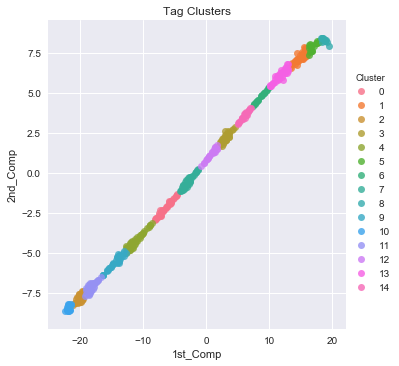

In [23]:
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000, random_state=23,learning_rate=1000)
new_values = tsne_model.fit_transform(tokens)

kmeans = KMeans(n_clusters=15)
kmeans.fit(tokens)
clusters = kmeans.predict(tokens)

df_tsne = pd.DataFrame(new_values, columns=['1st_Comp', '2nd_Comp'])
df_tsne['Cluster'] = clusters

sns.lmplot(x='1st_Comp', y='2nd_Comp', data=df_tsne, hue='Cluster', fit_reg=False)
plt.title("Tag Clusters")

In [24]:
convert = {labels[word]: clusters[word] for word in range(len(labels))}

In [25]:
convert['God']

7

## Related Talks

In [26]:
data['related_talks'][0]

'[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning revolution!\', \'duration\': 1008, \'slug\': \'sir_ken_robinson_bring_on_the_revolution\', \'viewed_count\': 7266103}, {\'id\': 1738, \'hero\': \'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg\', \'speaker\': \'Ken Robinson\', \'title\': "How to escape education\'s death valley", \'duration\': 1151, \'slug\': \'ken_robinson_how_to_escape_education_s_death_valley\', \'viewed_count\': 6657572}, {\'id\': 2276, \'hero\': \'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg\', \'speaker\': \'Linda Cliatt-Wayman\', \'title\': \'How to fix a broken school? Lead fearlessly, love hard\', \'duration\': 1027, \'slug\': \'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard\', \'viewed_count\': 1617101}, {\'id\': 892, \'hero\': \'https://pe.tedcdn.com/ima

In [27]:
test = ast.literal_eval(data['related_talks'][0])

In [28]:
test[0]

{'duration': 1008,
 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
 'id': 865,
 'slug': 'sir_ken_robinson_bring_on_the_revolution',
 'speaker': 'Ken Robinson',
 'title': 'Bring on the learning revolution!',
 'viewed_count': 7266103}

In [29]:
test[0]['viewed_count']

7266103

In [31]:
data['related_views'] = 0

In [32]:
for ii in range(len(data)):
    less = ast.literal_eval(data['related_talks'][ii])
    related_views = []
    for ll in range(len(less)):
        related_views.append(less[ll]['viewed_count'])
    data['related_views'][ii] = np.mean(related_views)
        

In [33]:
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,Tags,related_views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,7346,10581,300,10704,4439,1174,209,24924,"[children, creativity, culture, dance, educati...",3027062
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,443,132,258,268,116,203,131,413,"[alternative energy, cars, climate change, cul...",1118767
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,395,166,104,230,54,146,142,230,"[computers, entertainment, interface design, m...",1846195
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,380,132,36,460,230,85,35,1070,"[MacArthur grant, activism, business, cities, ...",776189
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,5433,4606,67,2542,3736,248,61,2893,"[Africa, Asia, Google, demo, economics, global...",1907337


## Events

In [34]:
data['event'].unique()

array(['TED2006', 'TED2004', 'TED2005', 'TEDGlobal 2005', 'TEDSalon 2006',
       'TED2003', 'TED2007', 'TED2002', 'TEDGlobal 2007',
       'TEDSalon 2007 Hot Science', 'Skoll World Forum 2007', 'TED2008',
       'TED1984', 'TED1990', 'DLD 2007', 'EG 2007', 'TED1998',
       'LIFT 2007', 'TED Prize Wish', 'TEDSalon 2009 Compassion',
       'Chautauqua Institution', 'Serious Play 2008', 'Taste3 2008',
       'TED2001', 'TED in the Field', 'TED2009', 'EG 2008',
       'Elizabeth G. Anderson School', 'TEDxUSC', 'TED@State',
       'TEDGlobal 2009', 'TEDxKC', 'TEDIndia 2009',
       'TEDSalon London 2009', 'Justice with Michael Sandel',
       'Business Innovation Factory', 'TEDxTC',
       'Carnegie Mellon University', 'Stanford University',
       'AORN Congress', 'University of California', 'TEDMED 2009',
       'Royal Institution', 'Bowery Poetry Club', 'TEDxSMU',
       'Harvard University', 'TEDxBoston 2009', 'TEDxBerlin', 'TED2010',
       'TEDxAmsterdam', 'World Science Festival', 

In [61]:
data['event_class'] = 'Other'

In [62]:
for ii in range(len(data)):
    if data['event'][ii].count('TED20') >0:
        data['event_class'][ii] = 'Yearly TED Conference'
    elif data['event'][ii].count('TED19') >0:
        data['event_class'][ii] = 'Yearly TED Conference'
    elif data['event'][ii].count('TEDx') >0:
        data['event_class'][ii] = 'TEDx'
    elif data['event'][ii].count('TEDGlobal') >0:
        data['event_class'][ii] = 'TEDGlobal'
    elif data['event'][ii].count('TEDWomen') >0:
        data['event_class'][ii] = 'TEDWomen'
    if data['event'][ii].count('TEDSalon') >0:
        data['event_class'][ii] = 'TEDSalon'
    if data['event'][ii].count('TEDNYC') >0:
        data['event_class'][ii] = 'TEDNYC'
    else:
        pass

In [65]:
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,Tags,related_views,event_class
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,10581,300,10704,4439,1174,209,24924,"[children, creativity, culture, dance, educati...",3027062,Yearly TED Conference
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,132,258,268,116,203,131,413,"[alternative energy, cars, climate change, cul...",1118767,Yearly TED Conference
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,166,104,230,54,146,142,230,"[computers, entertainment, interface design, m...",1846195,Yearly TED Conference
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,132,36,460,230,85,35,1070,"[MacArthur grant, activism, business, cities, ...",776189,Yearly TED Conference
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,...,4606,67,2542,3736,248,61,2893,"[Africa, Asia, Google, demo, economics, global...",1907337,Yearly TED Conference


## Current Columns of interest:   
 - Comments
 - Duration
 - Film Date / Publish Date
 - Languages
 - Ratings (We may want to combine certain ones to bigger categories)
 - Tags? More work has to be done to consolidate unless we want 400 dummy variables. May not be too bad.
 - Mean # of Related video views
 - Event Class
 - Speaker Occupation? Worth it?
